<a href="https://colab.research.google.com/github/aliai22/BOVW-classification/blob/main/BOVW_Objects_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## unzipping the folder

In [ ]:
!unzip '/content/drive/MyDrive/Objects_Dataset_Images-20230305T073453Z-001.zip'

Archive:  /content/drive/MyDrive/Objects_Dataset_Images-20230305T073453Z-001.zip
  inflating: Objects_Dataset_Images/test/Soccer_Ball/image_0032.jpg  
  inflating: Objects_Dataset_Images/test/dollar_bill/image_0040.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0012.jpg  
  inflating: Objects_Dataset_Images/test/motorbike/image_0030.jpg  
  inflating: Objects_Dataset_Images/train/accordion/image_0011.jpg  
  inflating: Objects_Dataset_Images/train/accordion/image_0013.jpg  
  inflating: Objects_Dataset_Images/train/accordion/image_0007.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0016.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0001.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0003.jpg  
  inflating: Objects_Dataset_Images/test/Soccer_Ball/image_0046.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0010.jpg  
  inflating: Objects_Dataset_Images/train/motorbike/image_0008.jpg  
  inflating: Objects

## Importing Libraries

In [ ]:
import cv2
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## defining functions

In [ ]:
def read_images(path,target='train'):
  images = []
  category = []
  for folder in os.listdir(os.path.join(path, target)):
    for image in os.listdir(os.path.join(os.path.join(path, target), folder)):
      img = cv2.imread(os.path.join(path, target, folder, image))
      img = cv2.resize(img, (250,250)) # resizing
      images.append(img)
      category.append(folder)
  return images, np.array(category)

def get_descriptors(images):
  all_descs = []
  sift = cv2.xfeatures2d.SIFT_create()
  for image in images:
    keys, desc = sift.detectAndCompute(image,None)
    all_descs.append(desc)  
  return np.concatenate(all_descs), all_descs

def generate_codebook(descriptors, no_of_clusters):
  k_means = KMeans(n_clusters=no_of_clusters,
                   init='random',
                   n_init='auto',
                   random_state=7,
                   verbose=0
                   )
  k_means.fit(descriptors)
  joblib.dump(k_means, 'KMeans-model.joblib')
  return k_means.cluster_centers_

def frequency_vector(descriptors):
  kmeans = joblib.load('KMeans-model.joblib')
  freq_vec = []
  indices= []
  for i in range(0,len(descriptors)):
    for im in descriptors[i]:
      indice = kmeans.predict(im.reshape(1,-1))
      indices.append(indice)
    hist = np.histogram(indices, bins=np.arange(0,101))[0]
    #hist = hist / len(indices) # normalizing histogram
    freq_vec.append(hist)  
  return np.asarray(freq_vec)

def scale(features):
  scaler = StandardScaler()
  return scaler.fit_transform(features)

def shuffle(data,labels):
  np.random.seed(7)
  indices = np.random.permutation(data.shape[0])
  return data[indices],(labels)[indices]

def conf_matrix(true_label, preds, model):
  cm = confusion_matrix(true_label, preds)
  fig = plt.figure(figsize=(7,5))
  sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
  plt.show()

def perf_measures_from_conf_matrix(labels, preds, model): 
  cm = confusion_matrix(labels, preds)
  FPRs = dict()
  TPRs = dict()
  i = 0
  for each in model.classes_:
    TP = cm[i,i]
    FP = cm[i,:].sum() - TP
    FN = cm[:,1].sum() - TP
    TN = cm.sum().sum() - (TP+FP+FN)
    FPR = FP/(FP+TN)
    FPRs[each] = FPR
    TPR = TP/(TP+FN)
    TPRs[each] = TPR
    i+=1
  return FPRs, TPRs 

def quantitative_perf(test_data, labels, preds, model):
  print('Accuracy of the model: ', accuracy_score(model.predict(test_data), labels))
  print('F1 Score of the model: ', f1_score(labels, model.predict(test_data), average='weighted'))
  print()
  FPRs, TPRs = perf_measures_from_conf_matrix(labels,preds,model)
  for i in svm.classes_:
    print('False Positive Rate of ','"',i,'"', 'is: ' , FPRs[i])
    print('True Positive Rate of ' ,'"', i,'"' , 'is: ' , TPRs[i])
    print()

def qualitative_perf(features,labels, model):
  model = joblib.load(model)
  fig = plt.figure(figsize=(15,20))
  i= 0
  for image in features:
    predicted_label = model.predict(image[i].reshape(1,-1))
    true_label = labels[i]
    if true_label == predicted_label:
      border_color = 'green'
    else:
      border_color = 'red'
    fig.add_subplot(4,4,i+1)
    plt.imshow(images_test[i])
    plt.title('Actual: {}\nPrediction: {}'.format(true_label, predicted_label))
    plt.gca().spines['top'].set_color(border_color)
    plt.gca().spines['bottom'].set_color(border_color)
    plt.gca().spines['left'].set_color(border_color)
    plt.gca().spines['right'].set_color(border_color)
    plt.gca().title.set_color(border_color)
    i+=1
  plt.show()

def svm_clf(training_data, training_labels):
  # hyper parameter selection using gridsearchCV
  kernels = ['rbf', 'sigmoid']
  params_grid = {'C':np.logspace(-2, 1, 5),'gamma':np.logspace(-4, 0, 5), 'kernel':kernels}
  grid_search = GridSearchCV(SVC(random_state=7), param_grid=params_grid, cv=StratifiedKFold(shuffle=True, random_state=7))
  grid_search.fit(training_data, training_labels)
  searched_params = grid_search.best_params_
  C, gamma, kernel = searched_params.get('C'), searched_params.get('gamma'), searched_params.get('kernel')
  print(C)
  print(gamma)
  print(kernel)
  # fitting model
  svm = SVC(C=C,gamma=gamma, kernel=kernel, decision_function_shape='ovr', random_state=7)
  svm.fit(training_data, training_labels)
  # saving trained model
  joblib.dump(svm, 'svm-model.joblib')
  return svm

def RF_clf(training_data, training_labels):
  # applyting GridSearchCV
  rf_clf = RandomForestClassifier(random_state=7)
  para_grid = {'n_estimators':np.arange(50, 201, 50),
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
                'max_depth' : np.arange(4,11,1)
              }
  grid_search = GridSearchCV(estimator=rf_clf, param_grid=para_grid, cv=StratifiedKFold(shuffle=True, random_state=7))
  grid_search.fit(training_data, training_labels)
  params = grid_search.best_params_
  # creating random forest model
  n_estimators, max_features, max_depth, criterion = params.get('n_estimators'), params.get('max_features'), params.get('max_depth'), params.get('criterion')
  print(n_estimators)
  print(max_features)
  print(max_depth)
  print(criterion)
  RF = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, random_state=7)
  # training model
  RF.fit(training_data,training_labels)
  joblib.dump(RF, 'rf-model.joblib')
  return RF

## reading/displaying images

In [ ]:
# training images and their labels
images_train, labels_train = read_images('/content/Objects_Dataset_Images')

In [ ]:
# testing images and their labels
images_test, labels_test = read_images('/content/Objects_Dataset_Images', target='test')

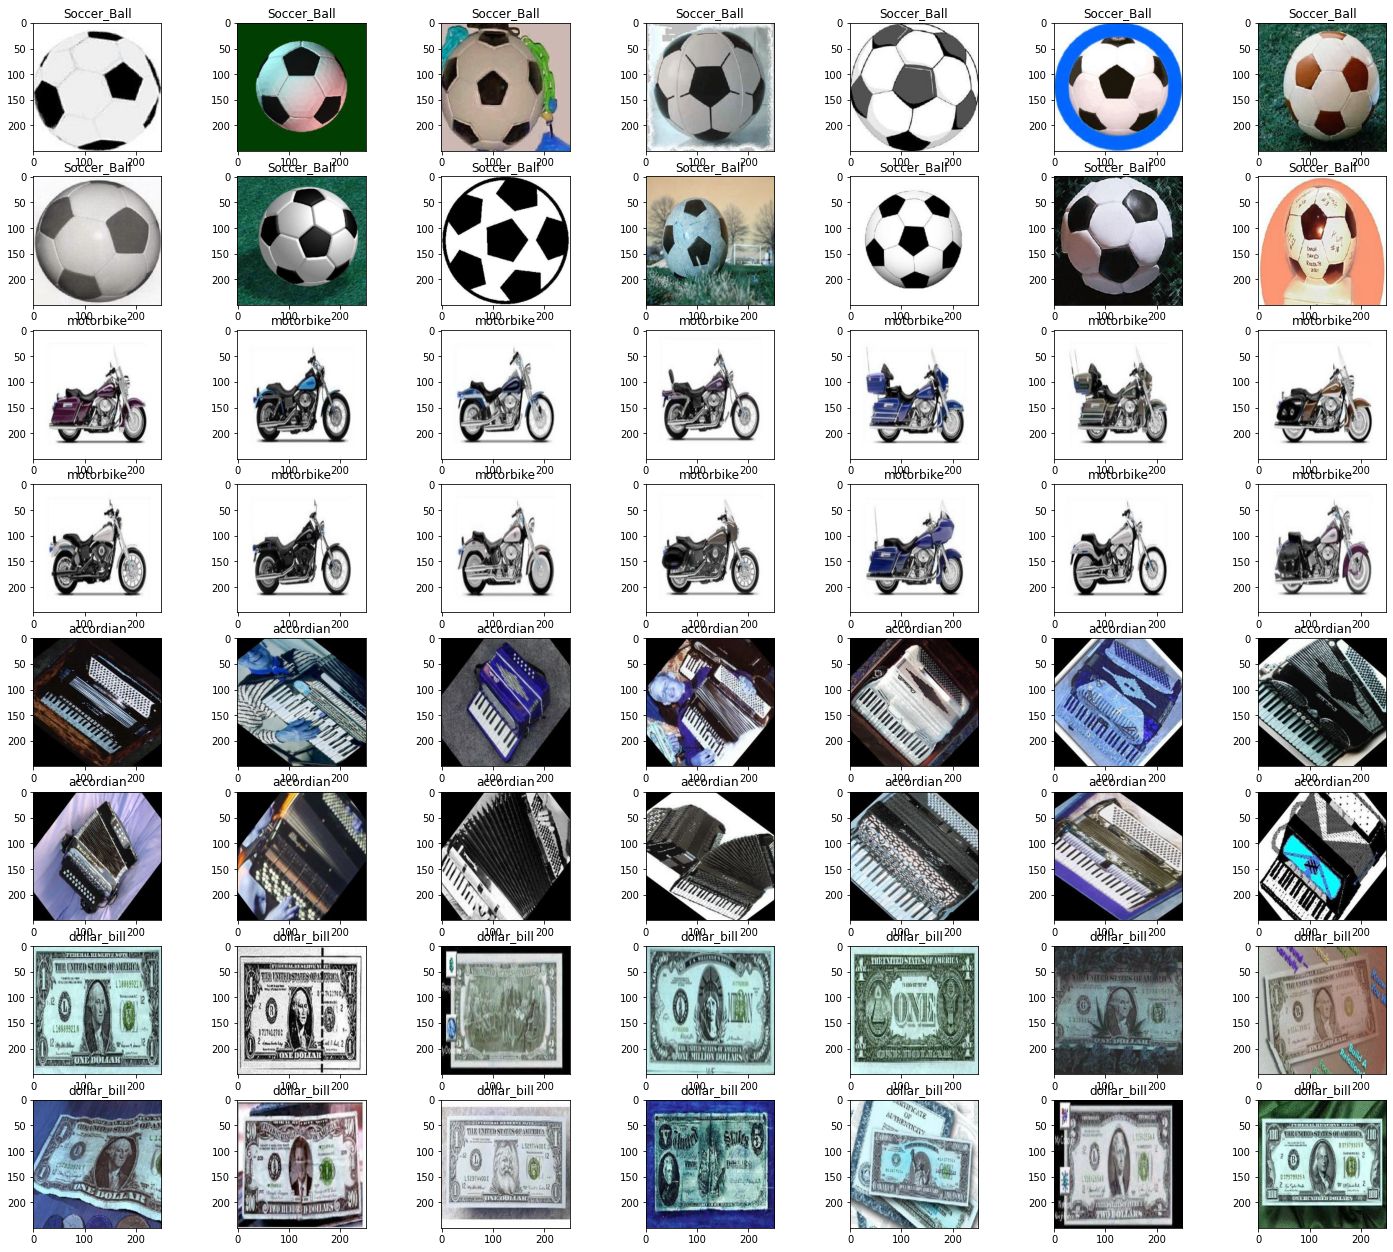

In [ ]:
# plotting training data
i = 0
fig = plt.figure(figsize=(25,25))
for image in images_train:
  fig.add_subplot(9,7,i+1)
  plt.imshow(image)
  plt.title(labels_train[i])
  i+=1

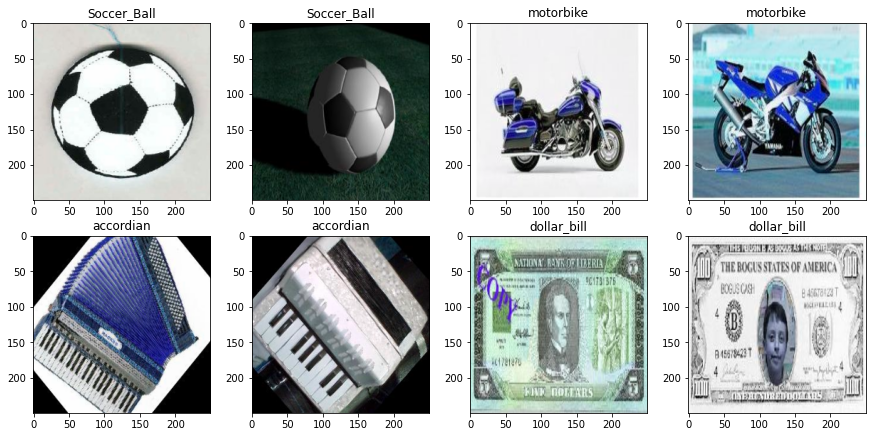

In [ ]:
# plotting testing data
i = 0
fig = plt.figure(figsize=(15,15))
for image in images_test:
  fig.add_subplot(4,4,i+1)
  plt.imshow(image, cmap=plt.cm.gray)
  plt.title(labels_test[i])
  i+=1

## Getting descriptors

In [ ]:
# descriptors for training data
descriptors_train, descriptors_per_train_image = get_descriptors(images_train)
print(descriptors_train.shape)
print(len(descriptors_per_train_image))

(29801, 128)
56


In [ ]:
# descriptors for testing data
descriptors_test, descriptors_per_test_image = get_descriptors(images_test)
print(descriptors_train.shape)
print(len(descriptors_per_test_image))

(29801, 128)
8


## Creating Vocabulary

In [ ]:
vocab= generate_codebook(descriptors=descriptors_train, no_of_clusters=100)

In [ ]:
vocab.shape

(100, 128)

## Vector quantization (making histogram/frequency vectors for each image)

In [ ]:
freq_vec_train_images = frequency_vector(descriptors_per_train_image)
freq_vec_train_images.shape

(56, 100)

In [ ]:
freq_vec_test_images = frequency_vector(descriptors_per_test_image)
freq_vec_test_images.shape

(8, 100)

## scaling the histogram vectors

In [ ]:
scaled_train = scale(freq_vec_train_images)
scaled_test = scale(freq_vec_test_images)

In [ ]:
scaled_train.shape, scaled_test.shape

((56, 100), (8, 100))

## shuffling training data before feeding to classifier to remove any existing pattern

In [ ]:
X_train, y_train = shuffle(scaled_train, labels_train) 
X_test, y_test = shuffle(scaled_test, labels_test) 

## Classification using SVM

In [ ]:
svm = svm_clf(training_data = X_train, training_labels = y_train)

1.7782794100389228
0.1
rbf


In [ ]:
predictions_svm = svm.predict(X_test)

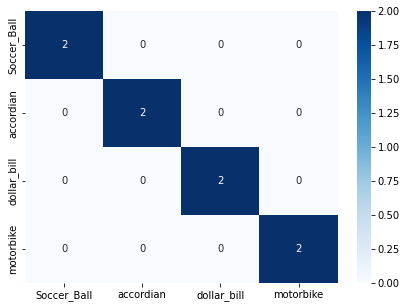

In [ ]:
conf_matrix(true_label=y_test, preds=predictions_svm, model=svm)

In [ ]:
FPRs, TPRs = perf_measures_from_conf_matrix(labels=y_test, preds=predictions_svm, model=svm)

In [ ]:
quantitative_perf(test_data=X_test, labels=y_test, preds=predictions_svm, model=svm)

Accuracy of the model:  1.0
F1 Score of the model:  1.0

False Positive Rate of  " Soccer_Ball " is:  0.0
True Positive Rate of  " Soccer_Ball " is:  1.0

False Positive Rate of  " accordian " is:  0.0
True Positive Rate of  " accordian " is:  1.0

False Positive Rate of  " dollar_bill " is:  0.0
True Positive Rate of  " dollar_bill " is:  1.0

False Positive Rate of  " motorbike " is:  0.0
True Positive Rate of  " motorbike " is:  1.0



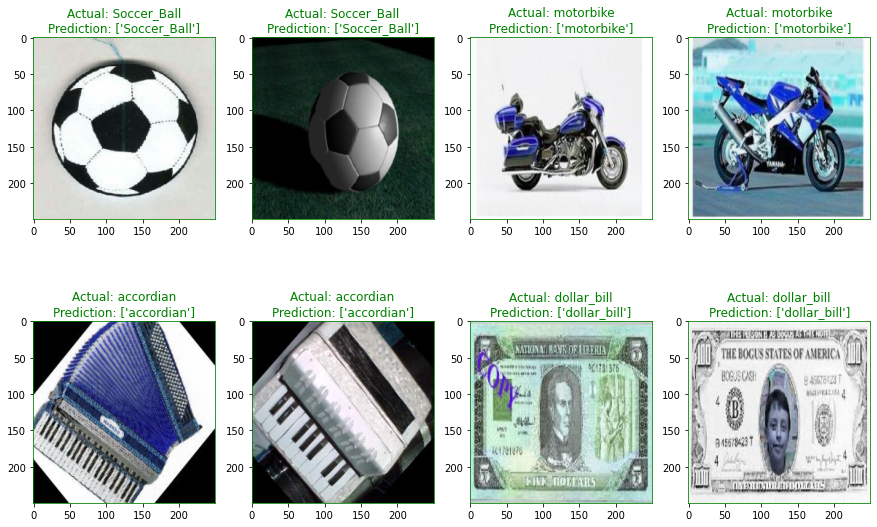

In [ ]:
qualitative_perf(features=scaled_test,labels=labels_test,model='svm-model.joblib')

## Random Forest classification

In [ ]:
predictions_rf = RF.predict(X_test)

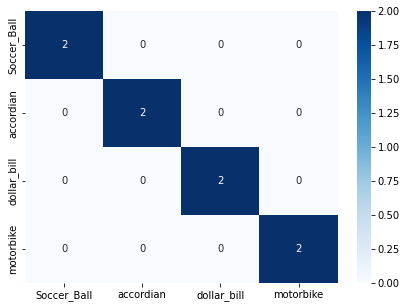

In [ ]:
conf_matrix(true_label=y_test, preds=predictions_svm, model=RF)

In [ ]:
FPRs, TPRs = perf_measures_from_conf_matrix(labels=y_test, preds=predictions_rf, model=RF)

In [ ]:
quantitative_perf(test_data=X_test, labels=y_test, preds=predictions_rf, model=RF)

Accuracy of the model:  1.0
F1 Score of the model:  1.0

False Positive Rate of  " Soccer_Ball " is:  0.0
True Positive Rate of  " Soccer_Ball " is:  1.0

False Positive Rate of  " accordian " is:  0.0
True Positive Rate of  " accordian " is:  1.0

False Positive Rate of  " dollar_bill " is:  0.0
True Positive Rate of  " dollar_bill " is:  1.0

False Positive Rate of  " motorbike " is:  0.0
True Positive Rate of  " motorbike " is:  1.0



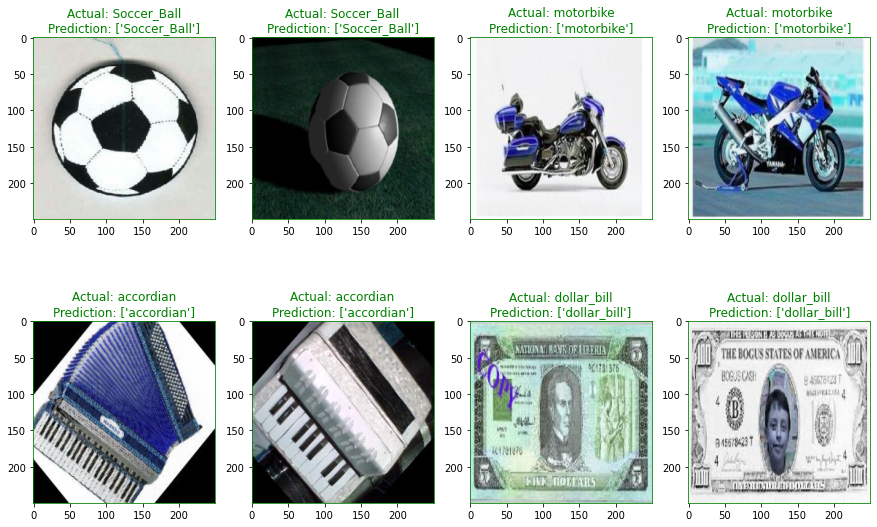

In [ ]:
qualitative_perf(features=scaled_test,labels=labels_test,model='rf-model.joblib')